# Initial analysis of cfDNA data 

With 2024 Hou paper used as reference

In [1]:
import pandas as pd
import sys
import subprocess
import numpy as np
import seaborn as sns
# import pybedtools
# from pybedtools import BedTool
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

The files used in this notebook are:
- bile duct cancer frag file subsampled to 50k rows (FinaleDB, Crisitano dataset)
- open chromatin regions (DNAseq - E029,E032,E034 and ATACseq reqions for pancancer) merged to a single file, supposed to be around 560k row, but TODO currently at around 800k. Filtered to only use autosomes and with added a 'chr' prefix to the chromosome name column.
- tss_150_50 and tss_1000_1000 - bed files of flanking regions, created for comparison (as mentioned in the paper)

All sources linked in the protocol.txt file

In [2]:
fragments_path = './data/subsampled/bileduct_subsample.bed'
openchrom_path = './data/processing/openchrom_200bp.bed'
tss_150_50_path = './data/processing/tss_150_50.bed'
tss_1000_1000_path = './data/processing/tss_1000_1000.bed'

#### **Load frag file**

In [3]:
fragments = pd.read_csv(fragments_path, sep='\t', header=None)
fragments.columns = ['chrom', 'start', 'end', 'score', 'strand']
print(fragments['chrom'].value_counts())
fragments.shape

chrom
chr2     4435
chr1     4150
chr4     3611
chr3     3563
chr5     3336
chr6     3041
chr7     2840
chr8     2730
chr10    2552
chr11    2392
chr12    2390
chr9     2196
chr13    1741
chr14    1654
chr16    1639
chr15    1545
chr18    1448
chr17    1386
chr20    1159
chr19     918
chr21     693
chr22     581
Name: count, dtype: int64


(50000, 5)

#### **Load open chromatin region union file**

In [4]:
openchrom = pd.read_csv(
    openchrom_path,
    sep="\t",
    header=None,
    names=["chrom", "start", "end"]
)
openchrom.shape

(732157, 3)

#### **Create intersection using bedtools**

(using the subprocess library because couldnt get pybedtools to work)

https://bedtools.readthedocs.io/en/latest/content/tools/intersect.html

In [10]:
# # run only once
# subprocess.run(f"bedtools intersect -a {fragments_path} -b {openchrom_path} -wa > data/subsampled/fragments_in_openchrom.bed", shell=True)

# # # load results
# df_fragments_in_openchrom = pd.read_csv("./data/subsampled/fragments_in_openchrom.bed", sep="\t", header=None,
#                  names=["chrom","start","end","score","strand"])

#### **Updated version**

In [ ]:
# # TODO create centroid column, will use it to select fragments whose centroids fell within open chromatin regions
# df = pd.read_csv(fragments_path, sep="\t", names=["chrom", "start", "end", "score", "strand"])

# df["centroid"] = ((df["start"] + df["end"]) // 2).astype(int)
# # bedtools expects start less than end?
# df_centroid = df[["chrom", "centroid", "centroid"]]  

# centroids_path = "./data/subsampled/fragments_centroids.bed"
# df_centroid.to_csv(centroids_path, sep="\t", header=False, index=False)

In [ ]:
# # intersect the fragment centroid file with the 200bp openchrom regions
# centroids_in_openchrom_path = "./data/subsampled/fragments_centroids_in_openchrom.bed"
# subprocess.run(f"bedtools intersect -a {centroids_path} -b {openchrom_path} -wa > {centroids_in_openchrom_path}", shell=True)

CompletedProcess(args='bedtools intersect -a ./data/subsampled/fragments_centroids.bed -b ./data/processing/openchrom_200bp.bed -wa > ./data/subsampled/fragments_centroids_in_openchrom.bed', returncode=0)

In [ ]:
# centroids_in_openchrom = pd.read_csv(centroids_in_openchrom_path, sep="\t",
#                            names=["chrom", "centroid", "centroid2"])

# df_in_open = df[df["centroid"].isin(centroids_in_openchrom["centroid"])]
# print(df_in_open.shape)
# df_in_open.head()

(2828, 6)


,chrom,start,end,score,strand,centroid
9,chr13,24299920,24300081,60,+,24300000
23,chr1,159808496,159808650,60,+,159808573
27,chr1,214965402,214965536,60,+,214965469
50,chr6,57501172,57501342,60,-,57501257
58,chr19,8430569,8430700,60,-,8430634


#### **Updated version 2** 
- **we need to identify which region it intersected with**

In [5]:
# TODO create centroid column, will use it to select fragments whose centroids fell within open chromatin regions
df_fragments = pd.read_csv(fragments_path, sep="\t", names=["chrom", "f_start", "f_end", "score", "strand"])

df_fragments["centroid"] = ((df_fragments["f_start"] + df_fragments["f_end"]) // 2).astype(int)
# bedtools expects start less than end?
df_centroid = df_fragments[["chrom", "centroid", "centroid"]]  

centroids_path = "./data/subsampled/fragments_centroids.bed"
df_centroid.to_csv(centroids_path, sep="\t", header=False, index=False)

In [6]:
# intersect the fragment centroid file with the 200bp openchrom regions
centroids_with_regions_path = "./data/subsampled/centroids_with_regions.bed"
subprocess.run(f"bedtools intersect -a {centroids_path} -b {openchrom_path} -wa -wb > {centroids_with_regions_path}", shell=True)

CompletedProcess(args='bedtools intersect -a ./data/subsampled/fragments_centroids.bed -b ./data/processing/openchrom_200bp.bed -wa -wb > ./data/subsampled/centroids_with_regions.bed', returncode=0)

In [10]:
centroids_with_regions = pd.read_csv(centroids_with_regions_path, sep="\t",
                           names=["f_chrom", "centroid1", "centroid2", "oc_chrom", "oc_start", "oc_end"])
openchrom = pd.read_csv(openchrom_path, sep="\t", 
                        names=["oc_chrom", "oc_start", "oc_end"])
openchrom["region_id"] = openchrom.index

region_id_map = {
    (row.oc_chrom, row.oc_start, row.oc_end): row.region_id
    for row in openchrom.itertuples(index=False)
}
centroids_with_regions["region_id"] = centroids_with_regions.apply(
    lambda row: region_id_map[(row["oc_chrom"], row["oc_start"], row["oc_end"])],
    axis=1
)
centroids_with_regions.head()
centroids_with_regions = centroids_with_regions.merge(
    df_fragments,
    left_on=["f_chrom", "centroid1", "centroid2"],
    right_on=["chrom", "centroid", "centroid"],
    how="left"
)
centroids_with_regions = centroids_with_regions[[
    "f_chrom", "centroid", "f_start", "f_end", "oc_chrom", "oc_start", "oc_end",
     "score", "strand", "region_id"
]]
print("openchrom:")
print(openchrom.shape)
display(openchrom.head())
print("centroids_with_regions:")
print(centroids_with_regions.shape)
centroids_with_regions.head()



openchrom:
(732157, 4)


,oc_chrom,oc_start,oc_end,region_id
0,chr1,10194,10394,0
1,chr1,17388,17588,1
2,chr1,96514,96714,2
3,chr1,102859,103059,3
4,chr1,136644,136844,4


centroids_with_regions:
(2831, 10)


,f_chrom,centroid,f_start,f_end,oc_chrom,oc_start,oc_end,score,strand,region_id
0,chr13,24300000,24299920,24300081,chr13,24299923,24300123,60,+,530112
1,chr1,159808573,159808496,159808650,chr1,159808539,159808739,60,+,42528
2,chr1,214965469,214965402,214965536,chr1,214965417,214965617,60,+,60310
3,chr6,57501257,57501172,57501342,chr6,57501151,57501351,60,-,278523
4,chr19,8430634,8430569,8430700,chr19,8430477,8430677,60,-,670938


Now we have created a dataframe of fragments whose centroids lie within the 200bp openchrom windows, with **each region having a unique id.**
This resulted in 2831 fragments for our 50000 subsample.

### LENGTH
2024 Hou et.al. Experimental section:

'For each autosome, fragments shorter than 300 bp were
divided into 30 categories at 10 bp intervals, whereas those longer than
300 bp were grouped into a single category. Consequently, a feature vector
of length 31 × 22 was generated for each sample.'

$
\textcolor{red}{TODO}
$
 skontrolovat

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, inf]
shape of feature matrix: (22, 31)


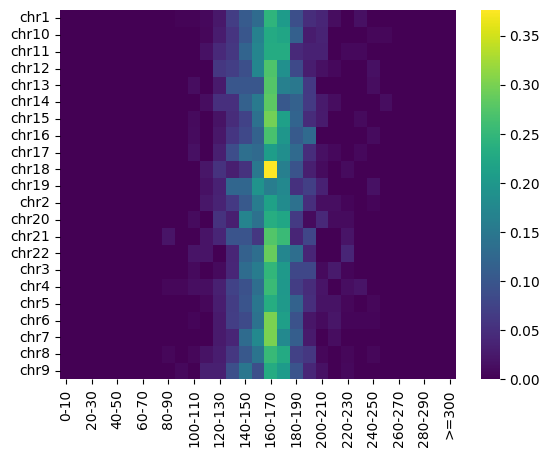

In [12]:
bin_edges = list(range(0, 310, 10)) + [np.inf] 
print(bin_edges)
bin_labels = [f"{i}-{i+10}" for i in range(0, 300, 10)] + [">=300"]

length_vectors = {}

for autosome_name in sorted(fragments["chrom"].unique()):
    # get length of fragments in open chromatin (end - start)
    autosome = centroids_with_regions[centroids_with_regions["f_chrom"] == autosome_name]
    lengths = autosome["f_end"] - autosome["f_start"]

    binned = pd.cut(lengths, bins=bin_edges, labels=bin_labels, right=False)

    bin_counts = binned.value_counts().sort_index()
    bin_proportions = bin_counts / bin_counts.sum()

    length_vectors[autosome_name] = bin_proportions

length_matrix = pd.DataFrame(length_vectors).fillna(0).T

sns.heatmap(length_matrix, cmap="viridis")
print(f"shape of feature matrix: {(length_matrix.shape)}")
    

### PFE

'after tallying the selected fragments, they were cat-
egorized as shorter than 100 bp, and longer than 250 bp, and those rang-
ing from 100–250 bp were further divided into 15 categories at 10 bp in-
tervals. Fragment proportions in each category were computed and the
entropy value for that speciﬁc region was calculated using the following
formula'

$
    \text{PFE} = -\sum_iP_i\log_2P_i 
$

where P_i is the raio of fragments in the ith category

$
\textcolor{red}{TODO}
$
 we selected fragments whose centroids fell within the binned openchrom regions. now **iterating over ALL the regions, we calculate PFE using only these selected fragments**.

i think indexing / ids need to be created to differentiate each region

In [ ]:
# # 1 bin below 100bp
# # 15 bins 100-250bp
# # 1 bin above 250bp


bins_pfe = [0,100] + list(range(110, 260, 10)) + [np.inf]
bin_labels_pfe = [f"{bins_pfe[i]}-{bins_pfe[i+1]}" for i in range(len(bins_pfe)-1)]
# print(bins_pfe)
pfe = {}
# TODO groupby
for region_id, group in openchrom.groupby("region_id"):
    lengths = group["f_end"] - group["f_start"]

    binned = pd.cut(lengths, bins=bins_pfe, labels=bin_labels_pfe, right=False)
    Pi = binned.value_counts(normalize=True)

   

### FSR

$
\textcolor{red}{TODO}
$

'selected fragments were tallied and divided into
3 categories based on their lengths: short (65–150 bp), medium (151–
220 bp), and long (221–400 bp). The fragment proportion in each category
was calculated and each sample had 561414 × 3 features.'

In [13]:
# i havent confirmed this but i am guessing that 65 is the shortest and 400 is the longest recorded in the dataset, otherwise we would leave out multiple fragments
# 1 bin 65-150bp
# 1 bin 151-220bp
# 1 bin above 221-400bp

bins_fsr = [65, 151, 221, 400]
bin_labels_fsr = [f"{bins_fsr[i]}-{bins_fsr[i+1]}" for i in range(len(bins_fsr)-1)]

fsr = {}

for region in openchrom.itertuples(index=False):
    chrom = region.chrom
    start = region.start
    end = region.end

    fragments_in_region = df_in_open[
        (df_in_open["chrom"] == chrom) &
        (df_in_open["start"] >= start) &
        (df_in_open["end"] <= end)
    ]
    binned = pd.cut(lengths, bins=bins_fsr, labels=bin_labels_fsr, right=False)

    bin_counts = binned.value_counts().sort_index()
    frag_proportions = bin_counts / bin_counts.sum()

    fsr[autosome_name] = frag_proportions

df_fsr = pd.DataFrame.from_dict(fsr, orient="index").reset_index()
df_fsr.rename(columns={"index": "chrom"}, inplace=True)

print(f"shape of df_fsr: {(df_fsr.shape)}")
print(df_fsr.head())
# sns.heatmap(df_fsr.set_index("chrom"), cmap="viridis")

NameError: name 'autosome_name' is not defined

### FSD

"all selected fragments were tallied. Those with
lengths ranging from 65 to 400 bp were divided into 67 categories at 5 bp
intervals, and the fragment proportions in each category were calculated.
Therefore, each sample contained 67 × 22 features"

In [15]:
intervals = list(range(65, 405, 5)) 
length_vectors = {}
for region in openchrom:
    # get fragment proportions in length intervals
    pass

### coverage

"selected fragments were tallied. For each
sample, the features consisted of a vector of size 561414 × 1 (for subsequent
fragmentation patterns, the number of features for each sample was
561414 × 1 unless otherwise specified)."

In [ ]:
for region in openchrom:
    # count number of fragments whole within it.
    pass

### end

"the number of fragment ends within each open
chromatin region was counted."

In [16]:
for region in openchrom:
    # count number of fragments ending within it.
    pass

###  OCF

"coordinates of the position with the smaller fragment
genome (U) and that with the larger fragment genome (D) on each
chromosome were determined with the corresponding counts. For each
open chromatin region, a 20 bp range was selected based on a 60 bp shift
upstream and downstream of the centroid. The OCF of the region was
calculated using the following equation:"

$
\mathrm{OCF} = - \sum_{-60-10}^{-60+10} (D - U) \;+\; \sum_{60-10}^{60+10} (U - D)
$

### IFS

"the fragments (n) within each open chromatin region including
the fragment centroid were counted and their average length (l)
within the region was calculated. L represents the average fragment length
of the whole chromosome. The calculation formula is as follows:"

$
placeholder = eq
$

### WPS

"according to the genomic coordinate position of each
cfDNA fragment, a window of 120 bp was slid at 1 bp intervals, and the
likelihood of each base pair being covered at the whole genome level, fully
covered (+1), and partially covered (−1), was counted. The mean value of
all loci within each open chromatin region was calculated."

### EDM

"the EDM consisting of 4 bases at the 5′ end of the cfDNA
fragment whose fragment centroid was within the open chromatin region
was viewed. The proportion of each EDM on each chromosome was
counted separately. Therefore, for each sample, the feature had a vector of
size 256 × 22."